In [1]:
import pickle
from utils import *
from model import *
from IPython.display import SVG, display
from keras.models import load_model
from tqdm import tqdm_notebook as tqdm

Using TensorFlow backend.


In [2]:
# Load the processed data
with open('tSVO_rd.p', 'rb') as f:
    verbs, objects, pairs, = pickle.load(f)

In [3]:
# Instantiate the core model
base = base_model(num_verbs=len(verbs)+1, sentence_space=60, loss='binary_crossentropy')

## Base model
The base model accepts 2 (Verb, Object) tuples. Each tuple is converted to a vector sequence and passed through a recurrent function which outputs a phrasal embedding. The cosine distance of the two embeddings is computed, and then passed through a linear regression layer that predicts whether the two phrases are semantically close. 

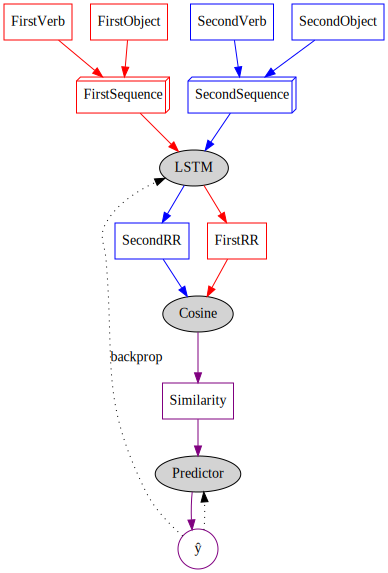

In [4]:
display(SVG(filename='Base_model.svg'))

In [43]:
# The model is rather shallow so just a few epochs should suffice
h = base.fit_generator(data_generator(verbs, objects, pairs,random_chance = 0.6, return_signatures=False, shuffle=True),
                       steps_per_epoch=100, nb_epoch=50, verbose=True)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., verbose=True, epochs=30, steps_per_epoch=100)`
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/30
100/100 [==============================] - 14s 141ms/step - loss: 2.3022 - predictor_loss: 2.3022 - predictor_acc: 0.5011
Epoch 2/30
100/100 [==============================] - 14s 137ms/step - loss: 1.0518 - predictor_loss: 1.0518 - predictor_acc: 0.5341
Epoch 3/30
100/100 [==============================] - 14s 136ms/step - loss: 0.9365 - predictor_loss: 0.9365 - predictor_acc: 0.5259
Epoch 4/30
100/100 [==============================] - 14s 138ms/step - loss: 0.8985 - predictor_loss: 0.8985 - predictor_acc: 0.5216
Epoch 5/30
100/100 [==============================] - 14s 138ms/step - loss: 0.8528 - predictor_loss: 0.8528 - predictor_acc: 0.5252
Epoch 6/30
100/100 [==============================] - 14s 141ms/step - loss: 0.8274 - predictor_loss: 0.8274 - predictor_acc: 0.5244
Epoch 7/30
100/100 [==============================] - 14s 136ms/step - loss: 0.7655 - predictor_loss: 0.7655 - predictor_acc: 0.5438
Epoch 8/30
100/100 [==============================] - 14s 136ms/step 

0.980104166667 0.887916666667


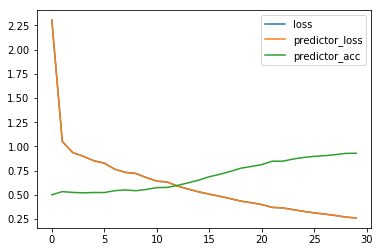

In [44]:
_, _, base_TPR, = base.evaluate_generator(generator=(data_generator(verbs, objects, pairs, random_chance = 0, return_signatures=False, index=0)),
                                         steps=150) # TPR is the accuracy at 0% random chance
_, _, base_TNR  = base.evaluate_generator(generator=(data_generator(verbs, objects, pairs, random_chance = 1, return_signatures=False, index=0)),
                                         steps=150) # TNR is the accuracy at 100% random chance
print(base_TPR, base_TNR)
histplot(h.history)

In [45]:
# Now instantiate the mapping model
mapper = mapping_model(base, sentence_space=60, num_verbs=len(verbs)+1, freeze=True,
                       loss='binary_crossentropy', embedding_activation='linear', lr=0.0001)

## Mapping model
The model extends the base model by accepting two additional inputs, the one-hot encodings of the two verbs. It (optionally) freezes the base model, disallowing further training of the recurrent and regression layers. The verb encodings are embedded to 2nd-order tensors. These, multiplied by the object vectors, produce a new pair of phrasal embeddings. 

The objective function is multi-fold; 
1. the recurrent and matmul embeddings need to **always** be classified as a paraphrase (for each of the two phrases),
2. the matmul embeddings of the two phrases need to be classified as a paraphrase depending on the training sample

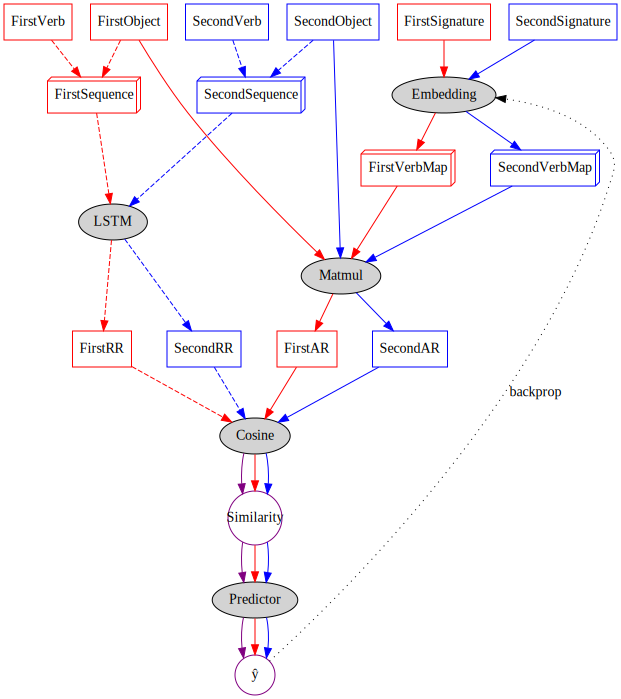

In [46]:
display(SVG(filename='Embedding.svg'))

In [47]:
# Fitting the mapping model requires more negative samples, larger batch size, more epochs and a slower learning rate to get good results
g = mapper.fit_generator(data_generator(verbs, objects, pairs,
                                        random_chance=0.75, batch_size = 128, 
                                        return_signatures=True, shuffle=True),
                         steps_per_epoch=125, nb_epoch=200, verbose=True)
# a reset over the trainset happens approximately every num_samples / (batch_size * steps * (1-random_chance)) epochs

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., verbose=True, epochs=200, steps_per_epoch=125)`
  """


Epoch 1/200
125/125 [==============================] - 49s 390ms/step - loss: 2.2592 - acc: 0.8296 - reconstruction_accuracy_1: 0.5860 - reconstruction_accuracy_2: 0.5985
Epoch 2/200
125/125 [==============================] - 49s 392ms/step - loss: 1.4652 - acc: 0.8602 - reconstruction_accuracy_1: 0.9169 - reconstruction_accuracy_2: 0.9243
Epoch 3/200
125/125 [==============================] - 51s 404ms/step - loss: 1.2442 - acc: 0.8715 - reconstruction_accuracy_1: 0.9406 - reconstruction_accuracy_2: 0.9489
Epoch 4/200
125/125 [==============================] - 50s 400ms/step - loss: 1.1306 - acc: 0.8820 - reconstruction_accuracy_1: 0.9438 - reconstruction_accuracy_2: 0.9534
Epoch 5/200
125/125 [==============================] - 50s 403ms/step - loss: 1.0554 - acc: 0.8868 - reconstruction_accuracy_1: 0.9427 - reconstruction_accuracy_2: 0.9574
Epoch 6/200
125/125 [==============================] - 51s 408ms/step - loss: 1.0157 - acc: 0.8849 - reconstruction_accuracy_1: 0.9442 - reconstr

125/125 [==============================] - 47s 375ms/step - loss: 0.7679 - acc: 0.8949 - reconstruction_accuracy_1: 0.9483 - reconstruction_accuracy_2: 0.9583
Epoch 49/200
125/125 [==============================] - 47s 375ms/step - loss: 0.7673 - acc: 0.8940 - reconstruction_accuracy_1: 0.9485 - reconstruction_accuracy_2: 0.9577
Epoch 50/200
125/125 [==============================] - 48s 380ms/step - loss: 0.7843 - acc: 0.8916 - reconstruction_accuracy_1: 0.9449 - reconstruction_accuracy_2: 0.9532
Epoch 51/200
125/125 [==============================] - 47s 379ms/step - loss: 0.7785 - acc: 0.8947 - reconstruction_accuracy_1: 0.9435 - reconstruction_accuracy_2: 0.9532
Epoch 52/200
125/125 [==============================] - 47s 379ms/step - loss: 0.7771 - acc: 0.8939 - reconstruction_accuracy_1: 0.9447 - reconstruction_accuracy_2: 0.9556
Epoch 53/200
125/125 [==============================] - 47s 378ms/step - loss: 0.7792 - acc: 0.8911 - reconstruction_accuracy_1: 0.9435 - reconstruction_

125/125 [==============================] - 47s 376ms/step - loss: 0.7490 - acc: 0.8942 - reconstruction_accuracy_1: 0.9472 - reconstruction_accuracy_2: 0.9579
Epoch 96/200
125/125 [==============================] - 48s 381ms/step - loss: 0.7481 - acc: 0.8944 - reconstruction_accuracy_1: 0.9469 - reconstruction_accuracy_2: 0.9585
Epoch 97/200
125/125 [==============================] - 47s 377ms/step - loss: 0.7564 - acc: 0.8937 - reconstruction_accuracy_1: 0.9445 - reconstruction_accuracy_2: 0.9561
Epoch 98/200
125/125 [==============================] - 47s 379ms/step - loss: 0.7547 - acc: 0.8944 - reconstruction_accuracy_1: 0.9447 - reconstruction_accuracy_2: 0.9571
Epoch 99/200
125/125 [==============================] - 47s 378ms/step - loss: 0.7633 - acc: 0.8886 - reconstruction_accuracy_1: 0.9427 - reconstruction_accuracy_2: 0.9553
Epoch 100/200
125/125 [==============================] - 47s 379ms/step - loss: 0.7660 - acc: 0.8909 - reconstruction_accuracy_1: 0.9430 - reconstruction

125/125 [==============================] - 47s 379ms/step - loss: 0.7509 - acc: 0.8942 - reconstruction_accuracy_1: 0.9455 - reconstruction_accuracy_2: 0.9541
Epoch 143/200
125/125 [==============================] - 48s 381ms/step - loss: 0.7489 - acc: 0.8949 - reconstruction_accuracy_1: 0.9444 - reconstruction_accuracy_2: 0.9565
Epoch 144/200
125/125 [==============================] - 47s 380ms/step - loss: 0.7485 - acc: 0.8941 - reconstruction_accuracy_1: 0.9455 - reconstruction_accuracy_2: 0.9557
Epoch 145/200
125/125 [==============================] - 48s 381ms/step - loss: 0.7407 - acc: 0.8986 - reconstruction_accuracy_1: 0.9479 - reconstruction_accuracy_2: 0.9547
Epoch 146/200
125/125 [==============================] - 47s 379ms/step - loss: 0.7499 - acc: 0.8933 - reconstruction_accuracy_1: 0.9444 - reconstruction_accuracy_2: 0.9569
Epoch 147/200
125/125 [==============================] - 47s 378ms/step - loss: 0.7447 - acc: 0.8941 - reconstruction_accuracy_1: 0.9463 - reconstruc

125/125 [==============================] - 47s 379ms/step - loss: 0.7543 - acc: 0.8935 - reconstruction_accuracy_1: 0.9429 - reconstruction_accuracy_2: 0.9519
Epoch 190/200
125/125 [==============================] - 47s 378ms/step - loss: 0.7458 - acc: 0.8926 - reconstruction_accuracy_1: 0.9453 - reconstruction_accuracy_2: 0.9553
Epoch 191/200
125/125 [==============================] - 48s 381ms/step - loss: 0.7452 - acc: 0.8926 - reconstruction_accuracy_1: 0.9440 - reconstruction_accuracy_2: 0.9574
Epoch 192/200
125/125 [==============================] - 47s 377ms/step - loss: 0.7457 - acc: 0.8924 - reconstruction_accuracy_1: 0.9461 - reconstruction_accuracy_2: 0.9550
Epoch 193/200
125/125 [==============================] - 47s 376ms/step - loss: 0.7460 - acc: 0.8924 - reconstruction_accuracy_1: 0.9456 - reconstruction_accuracy_2: 0.9544
Epoch 194/200
125/125 [==============================] - 47s 378ms/step - loss: 0.7409 - acc: 0.8967 - reconstruction_accuracy_1: 0.9465 - reconstruc

0.803333333333 0.922604166667


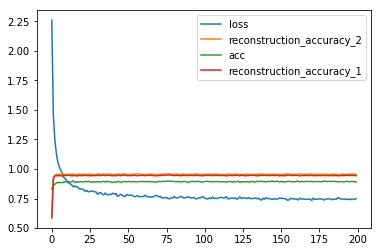

In [48]:
_, mapper_TPR, _, _ = mapper.evaluate_generator(generator=(data_generator(verbs, objects, pairs, random_chance = 0, 
                                                                          return_signatures=True, shuffle=True)),
                                         steps=150) # TPR is the accuracy at 0% random chance
_, mapper_TNR, _, _ = mapper.evaluate_generator(generator=(data_generator(verbs, objects, pairs, random_chance = 1, 
                                                                          return_signatures=True, shuffle=True)),
                                         steps=150) # TNR is the accuracy at 100% random chance
print(mapper_TPR, mapper_TNR)
histplot(g.history)

In [49]:
evaluator = evaluation_model(mapper, base, num_verbs=len(verbs)+1)

In [91]:
X = evaluator.predict_generator(generator=evaluation_generator(verbs, batch_size=105, index=1), steps=10)

In [94]:
with open('verb_embeddings.p', 'wb') as f:
    pickle.dump(X, f)